In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from numpy.random import seed
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
from more_itertools import powerset
from numpy import cov

%matplotlib inline
%config InlineBackend.figure_format = 'svg'    

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

sns.set()
warnings.filterwarnings('ignore')
random_seed = 10000
seed(random_seed)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('houses_dataset.csv', index_col = 'Id')
df = df._get_numeric_data()
df = df.dropna(axis='columns')
df_rows = df.shape[0]
zero_precents = df.astype(bool).apply(lambda x: ~x).sum(axis = 0) / df_rows
zero_columns_labels = list(zero_precents[zero_precents > 0.333].index)
df = df.drop(zero_columns_labels, axis = 1)
df = df.drop(['KitchenAbvGr'], axis = 1)
df.head(10)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,150,856,856,1710,2,3,8,2,548,2,2008,208500
2,20,9600,6,8,1976,1976,978,284,1262,1262,1262,2,3,6,2,460,5,2007,181500
3,60,11250,7,5,2001,2002,486,434,920,920,1786,2,3,6,2,608,9,2008,223500
4,70,9550,7,5,1915,1970,216,540,756,961,1717,1,3,7,3,642,2,2006,140000
5,60,14260,8,5,2000,2000,655,490,1145,1145,2198,2,4,9,3,836,12,2008,250000
6,50,14115,5,5,1993,1995,732,64,796,796,1362,1,1,5,2,480,10,2009,143000
7,20,10084,8,5,2004,2005,1369,317,1686,1694,1694,2,3,7,2,636,8,2007,307000
8,60,10382,7,6,1973,1973,859,216,1107,1107,2090,2,3,7,2,484,11,2009,200000
9,50,6120,7,5,1931,1950,0,952,952,1022,1774,2,2,8,2,468,4,2008,129900


## Correlation to Sale-Price

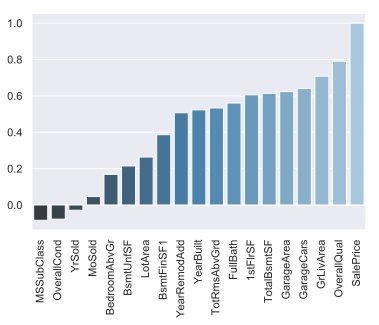

In [3]:
correlation = df.corr()['SalePrice'].sort_values()
dd = pd.DataFrame(correlation)
chart = sns.barplot(correlation.index, correlation.values, palette="Blues_d")
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [4]:
top_8_cats = abs(df.corr())['SalePrice'].sort_values(ascending=False)[1:(1+8)]
for cat in top_8_cats.index:
    print(cat)
data = df[list(top_8_cats.index) + ["SalePrice"]]

OverallQual
GrLivArea
GarageCars
GarageArea
TotalBsmtSF
1stFlrSF
FullBath
TotRmsAbvGrd


## Visualization

In [5]:
_ = sns.pairplot(data=data, y_vars=['SalePrice'], x_vars=data.columns, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'purple'}, 'scatter_kws': {'alpha': 0.2}})

# Correlation Heatmap

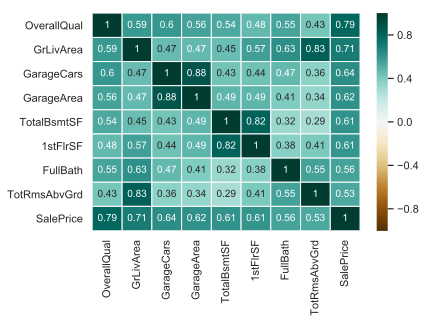

In [6]:
_ = sns.heatmap(data.corr(), cmap="BrBG", linewidths = 1, vmin = -1, vmax = 1, annot = True)

# Neural Network Training

In [7]:
test_precent = 0.15
train_precent = 1.0 - test_precent
train_data = data.sample(frac=train_precent, random_state=random_seed)
test_data = data.drop(train_data.index)

In [8]:
train_stats = train_data.describe().T
def normalize(x):
    result = x.copy()
    for feature_name in x.columns:
        average = x[feature_name].mean()
        std = x[feature_name].std()
        result[feature_name] = (x[feature_name] - average) / std
    return result
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)
normalized_train_data.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,SalePrice
Id,,,,,,,,,
1356,0.643370,0.746126,0.291487,0.043976,-1.103240,0.130061,2.583995,0.903746,-0.150385
1141,-0.801738,-1.073912,0.291487,1.708025,-0.254483,-0.554142,-1.041486,-1.559842,-0.530158
491,-0.801738,-0.412080,-1.063329,-0.667841,-1.783135,-1.405594,-1.041486,-1.559842,-0.824177
449,-0.079184,-0.276705,-1.063329,-1.318376,-0.636646,-0.990004,0.771255,0.287849,-0.769048
358,-0.801738,-0.716673,0.291487,0.237251,0.167674,-0.072666,-1.041486,-0.328048,-0.591412


In [9]:
train_x = normalized_train_data.drop('SalePrice', axis = 1)
train_y = normalized_train_data['SalePrice']
test_x = normalized_test_data.drop('SalePrice', axis = 1)
test_y = normalized_test_data['SalePrice']

In [10]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(10, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(10, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)
   
    model = Model(input=[input_layer], output=[output_layer])
    last_layer_model = Model(input=[input_layer], output=[hidden_layer_2])
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    

    return model, last_layer_model

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def train_model(model, X, Y, show_dots = True):
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
    callbacks=[mc, es]
    if show_dots:
        callbacks.append(PrintDot())
    history = model.fit(X, Y, epochs=200, validation_split = 0.33, verbose=0, callbacks=callbacks)
    model = load_model('best_nn_model.nn')
    return history, model

In [12]:
fully_NN_model, last_layer_NN_model = build_fully_NN_model(train_x)
fully_NN_history, fully_NN_model = train_model(fully_NN_model, train_x, train_y)


....................................................................................................
.................................................................................................

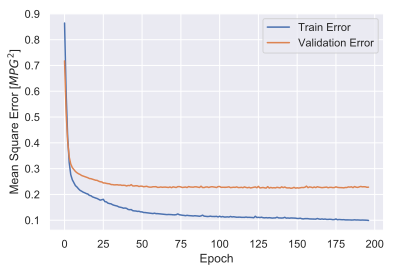

In [13]:
def plot_history(history):    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Validation Error')
    #plt.ylim([0,1000])
    plt.legend()
    plt.show()

plot_history(fully_NN_history)

## Test Set

Test Set MSE = 0.1534048616886139


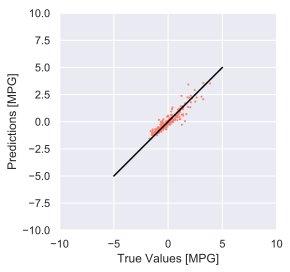

In [18]:
def show_test_predictions(name, model, test_X, test_Y):
    loss, mse = model.evaluate(test_X, test_Y, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(test_X).flatten()

    s = [1.5 for _ in range(len(test_x))]
    plt.scatter(test_Y, test_predictions, alpha = 0.9, color = 'salmon', s=s)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    _ = plt.plot([-5, 5], [-5, 5], color = 'black')
show_test_predictions('Test Set', fully_NN_model, test_x, test_y)

## Train Set

Train Set MSE = 0.15425102412700653


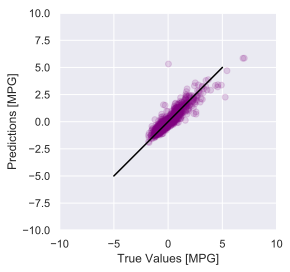

In [15]:
def show_test_predictions(name, model, testX, testY):
    loss, mse = model.evaluate(testX, testY, verbose=0)
    print(name + ' MSE = ' + str(mse))
    test_predictions = model.predict(testX).flatten()

    plt.scatter(testY, test_predictions, alpha = 0.15, color = 'purple')
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    _ = plt.plot([-5, 5], [-5, 5], color = 'black')
show_test_predictions('Train Set', fully_NN_model, train_x, train_y)

In [16]:
def evaluate(model, input_data):
    return model.predict(np.array([input_data]))[0][0]

def copy_and_add(data_list, dim_1, amount_1, dim_2, amount_2):
    data_list = data_list.copy()
    data_list[dim_1] += amount_1
    data_list[dim_2] += amount_2
    return data_list

def get_second_derivative(model, input_data, dim_1, dim_2):
    eps = 0.1
    f_pp = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, eps))
    f_mm = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, -eps))
    f_mp = evaluate(model, copy_and_add(input_data, dim_1, -eps, dim_2, eps))
    f_pm = evaluate(model, copy_and_add(input_data, dim_1, eps, dim_2, -eps))
    real_sec_dev = (f_pp + f_mm - f_mp - f_pm) / (4*eps*eps)
    direction_dev = (f_pp - f_mm) / (4*eps*eps)
    mixed_direction_dev = (f_pm - f_mp) / (4*eps*eps)
    return real_sec_dev, direction_dev, mixed_direction_dev

def get_first_derivative(model, input_data, dim):
    eps = 0.1
    f_plus_eps_val = evaluate(model, copy_and_add(input_data, dim, eps, 0, 0.0))
    f_val = evaluate(model, copy_and_add(input_data, dim_1, 0.0, 0, 0.0))
    return (f_plus_eps_val - f_val) / eps

def input_data_options(list_data):
    if (len(list_data) == 8):
        yield list_data
    else:
        for option in [0.3, 0.7]:
            list_data.append(option)
            for inner_res in input_data_options(list_data):
                yield inner_res
            list_data.pop()
sec_dev_table = np.zeros((8,8))
abs_sec_dev_table = np.zeros((8,8))
direction_dev_table = np.zeros((8,8))
abs_direction_dev_table = np.zeros((8,8))
mixed_direction_dev_table = np.zeros((8,8))
abs_mixed_direction_dev_table = np.zeros((8,8))
items_amount = 0
for input_data in input_data_options([]):
    items_amount += 1
    if (items_amount % 10 == 0):
        print('.', end='')
    for dim_1 in range(8):
        for dim_2 in range(8):
            real_sec_dev, direction_dev, mixed_direction_dev = get_second_derivative(fully_NN_model, input_data, dim_1, dim_2)
            sec_dev_table[dim_1, dim_2] += real_sec_dev
            abs_sec_dev_table[dim_1, dim_2] += abs(real_sec_dev)
            direction_dev_table[dim_1, dim_2] += direction_dev
            abs_direction_dev_table[dim_1, dim_2] += abs(direction_dev)
            mixed_direction_dev_table[dim_1, dim_2] += mixed_direction_dev
            abs_mixed_direction_dev_table[dim_1, dim_2] += abs(mixed_direction_dev)
sec_dev_table /= items_amount
abs_sec_dev_table /= items_amount
direction_dev_table /= items_amount
abs_direction_dev_table /= items_amount
mixed_direction_dev_table /= items_amount
abs_mixed_direction_dev_table /= items_amount

.........................

In [17]:
def to_df(hess_table):
    hessian_df = pd.DataFrame(hess_table, index = top_8_cats.index, columns=top_8_cats.index)
    return hessian_df
def display_heatmap(hess):
    hessian_df = to_df(hess)
    min_val = hessian_df.min().min()
    max_val = hessian_df.max().max()
    _ = sns.heatmap(hessian_df, cmap="BrBG", linewidths = 1, vmin = min_val, vmax = max_val, annot = True)

# cov matrix (df / dx_i, x_j)

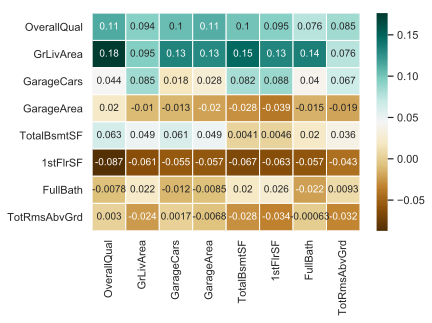

In [18]:
devs = dict([(i, []) for i in range(8)])
for row in range(train_x.shape[0]):
    row_vals = np.squeeze(np.array(train_x.iloc[[row],:]))
    for dim in range(8):
        devs[dim].append(get_first_derivative(fully_NN_model, row_vals, dim))
cov_mat = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        covariance = cov(devs[i], np.squeeze(np.array(train_x.iloc[:, [j]])))[0, 1]
        cov_mat[i,j] = covariance
display_heatmap(cov_mat)

# Hessian f(x+e,y+e)+f(x-e,y-e)-f(x+e,y-e)-f(x-e,y+e)

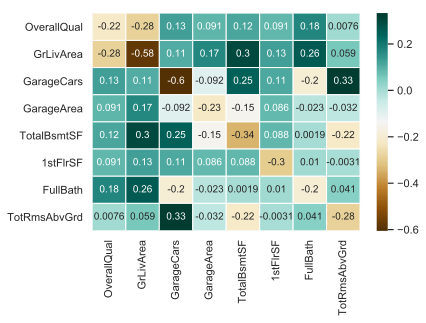

In [19]:
display_heatmap(sec_dev_table)

# Absolute Hessian |f(x+e,y+e)+f(x-e,y-e)-f(x+e,y-e)-f(x-e,y+e)|

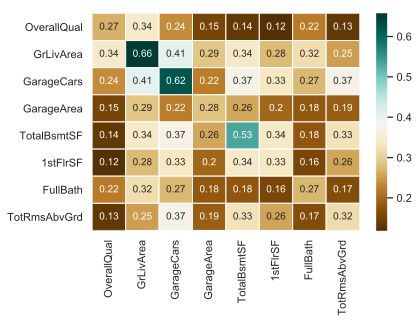

In [20]:
display_heatmap(abs_sec_dev_table)

# Directional Derivative f(x+e,y+e)-f(x-e,y-e)

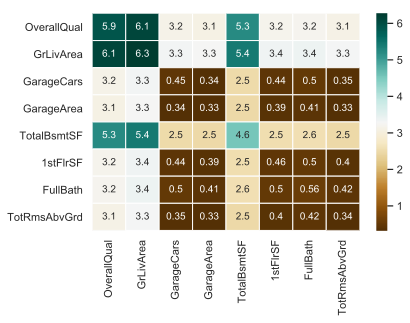

In [21]:
display_heatmap(direction_dev_table)

# Absolute Directional Derivative |f(x+e,y+e)-f(x-e,y-e)|

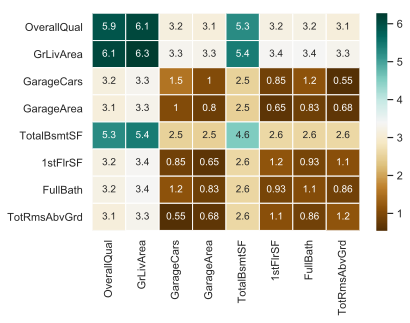

In [22]:
display_heatmap(abs_direction_dev_table)

# Mixed Directional Derivative f(x+e,y-e)-f(x-e,y+e)

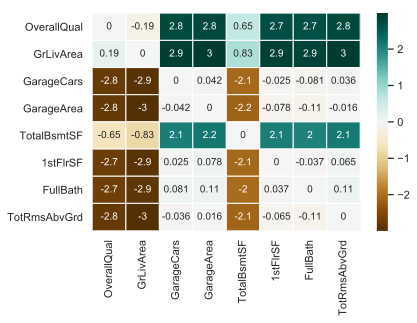

In [23]:
display_heatmap(mixed_direction_dev_table)

# Absolute Mixed Directional Derivative |f(x+e,y-e)-f(x-e,y+e)|

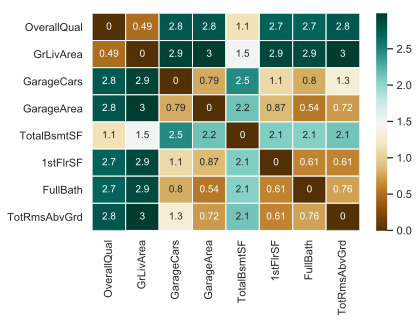

In [24]:
display_heatmap(abs_mixed_direction_dev_table)

# Prametric-Rank-Sum

In [25]:
def perform_parametric_rank_sum(hess, name):
    hess = to_df(hess)
    n_inputs = hess.shape[0]
    inputs = set(hess.columns)
    partitions = [(set(partition), inputs - set(partition))
                      for partition in powerset(inputs)
                      if len(partition) >=2 and len(partition) <= n_inputs - 2 and 'OverallQual' in partition]
    
    def extract_triangle(cols):
        data = hess.loc[cols, cols]
        data = data.where(np.triu(np.ones(data.shape)).astype(bool)).stack().to_numpy()
        return data
    
    triangular_samples = [((group1, extract_triangle(group1)), (group2, extract_triangle(group2)))
                          for group1, group2 in partitions]
    rank_sum_pvalues = [(g1, g2, ranksums(x=g1_data, y=g2_data).pvalue)
                        for ((g1, g1_data), (g2, g2_data)) in triangular_samples]
    pvalues = list(map(lambda c: c[2], rank_sum_pvalues))
    alpha = 0.05
    rank_sum_pvalues_adj = multipletests(pvals=pvalues, is_sorted = False, method = 'holm-sidak', alpha = alpha)[1]
    results = [(tuple(g1), tuple(g2), orig_pval)
               for ((g1, g2, orig_pval), adj_pval) in zip(rank_sum_pvalues, rank_sum_pvalues_adj)]
    sorted_results = list(sorted(results, key = lambda x: x[2]))
    sorted_results = [sorted_results[i] + ((i + 1,)) for i in range(len(sorted_results))]
    return pd.DataFrame(sorted_results, columns=['group1', 'group2', name+'_pvalue', name+'_pvalue_rank'])

# Prametric-Rank-Sum Absolute Hessian

In [26]:
sec_dev_table_rank_sum = perform_parametric_rank_sum(sec_dev_table,'dv_dv')
abs_sec_dev_table_rank_sum = perform_parametric_rank_sum(abs_sec_dev_table,'|dv_dv|')
direction_dev_table_rank_sum = perform_parametric_rank_sum(direction_dev_table,'dir_dv')
abs_direction_dev_table_rank_sum = perform_parametric_rank_sum(abs_direction_dev_table,'|dir_dv|')
mixed_direction_dev_table_rank_sum = perform_parametric_rank_sum(mixed_direction_dev_table,'mixed_dir')
abs_mixed_direction_dev_table_rank_sum = perform_parametric_rank_sum(abs_mixed_direction_dev_table,'|mixed_dir|')
cov_div_mat_table_rank_sum = perform_parametric_rank_sum(cov_mat,'cov_div')

# Prametric-Rank-Sum Hessian

In [27]:
merged_parametric_rank_sum = \
    sec_dev_table_rank_sum.merge(abs_sec_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(abs_direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(mixed_direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(abs_mixed_direction_dev_table_rank_sum, on=['group1','group2'], how='inner') \
                          .merge(cov_div_mat_table_rank_sum, on=['group1','group2'], how='inner')

In [28]:
def build_halved_model(group1, group2):
    input1 = Input(shape=(len(group1),))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)
    
    input2 = Input(shape=(len(group2),))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)
    
    merge = concatenate([out1, out2], name='merge')
    #hidden = Dense(4, activation='relu')(merge)
    #hidden_x = Dense(4)(hidden)
    output = Dense(1)(merge)
    
    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model
def calc_halved_NN_mse(g1, g2):
    values = []
    g1 = list(g1)
    g2 = list(g2)
    halved_train_X = [train_x[g1], train_x[g2]]
    halved_train_Y = train_y
    halved_test_X = [test_x[g1], test_x[g2]]
    halved_test_Y = test_y
    for i in range(3):
        halved_model = build_halved_model(g1, g2)
        _, halved_model = train_model(halved_model, halved_train_X, halved_train_Y, False)
        _, mse = halved_model.evaluate(halved_test_X, halved_test_Y, verbose=0)
        values.append(mse)
    return min(values)

In [29]:
groups = zip(merged_parametric_rank_sum['group1'], merged_parametric_rank_sum['group2'])
scores = [calc_halved_NN_mse(group1, group2) for (group1, group2) in groups]
merged_parametric_rank_sum['Halved_NN_MSE'] = scores

In [30]:
results = merged_parametric_rank_sum.sort_values(by = 'Halved_NN_MSE')
results.to_csv('prediction_results.csv')